# La predizione bayesiana {#sec-bayesian_prediction}

**Prerequisiti**

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from scipy.special import expit  # Funzione logistica
from cmdstanpy import cmdstan_path, CmdStanModel

# Configuration
seed = sum(map(ord, "stan_prediction"))
rng = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Define directories
home_directory = os.path.expanduser("~")
project_directory = f"{home_directory}/_repositories/psicometria"

# Print project directory to verify
print(f"Project directory: {project_directory}")

Project directory: /Users/corradocaudek/_repositories/psicometria


## Introduzione {.unnumbered}

In questo capitolo, approfondiremo il concetto e l'importanza delle distribuzioni predittive a priori e a posteriori nel contesto dell'analisi di dataset. La distribuzione predittiva a posteriori è cruciale per verificare l'aderenza delle previsioni del modello ai dati osservati. Un allineamento tra queste previsioni e i dati effettivamente raccolti ci consente di convalidare l'accuratezza del modello nel rappresentare il processo generativo sottostante.

Parallelamente, la distribuzione predittiva a priori modella le aspettative dei dati prima di qualsiasi osservazione effettiva. Essa integra le nostre conoscenze preesistenti e le ipotesi sui parametri del modello, fornendo un quadro essenziale per la proiezione e l'interpretazione di fenomeni complessi in un contesto statistico avanzato. Questa distribuzione non solo predispone una struttura per l'analisi inferenziale, ma è anche fondamentale per la formulazione di nuove ipotesi e per la progettazione di esperimenti futuri.

## La distribuzione predittiva a posteriori 

La distribuzione predittiva a posteriori (PPD) è un concetto essenziale nell'inferenza bayesiana e permette di valutare quanto bene un modello si adatti ai dati osservati. Secondo @gelman2013philosophy, questa metodologia fornisce una valutazione critica della coerenza tra i dati reali e quelli simulati dal modello. La verifica predittiva a posteriori (PPC) utilizza la PPD per confrontare direttamente i dati osservati con quelli generati dal modello, rivelando eventuali discrepanze che possono indicare problemi nella specificazione del modello. In pratica, la PPC funge da test diagnostico, consentendo di individuare e correggere eventuali lacune nel modello al fine di migliorarne le capacità predittive.

Per comprendere meglio il concetto, è utile considerare la distribuzione predittiva a posteriori in termini di un modello coniugato normale-normale. Supponiamo di voler predire la media di una distribuzione normale futura, basandoci sui dati osservati e sulle nostre conoscenze a priori. La PPD ci offre uno strumento per calcolare queste probabilità, combinando le informazioni provenienti dai dati osservati con quelle fornite dalla distribuzione a priori.

Ad esempio, immaginiamo di aver raccolto dati sulle altezze di 100 persone, ottenendo una media campionaria di 170 cm e una deviazione standard campionaria di 10 cm. Il nostro obiettivo è stimare la media delle altezze in un futuro campione di $n=100$ persone. La nostra conoscenza a priori sulla media delle altezze è rappresentata da una distribuzione normale con media 175 cm e deviazione standard di 5 cm. 

In termini di notazione, possiamo esprimere questa distribuzione come $P(\tilde{y}|\theta=\theta_1)$, dove $\tilde{y}$ rappresenta un nuovo dato che è diverso dai dati attuali $y$, e $\theta_1$ è la media a posteriori. Tuttavia, in statistica bayesiana, è fondamentale incorporare tutta l'incertezza nei risultati. Poiché $\theta_1$ è solo uno dei possibili valori per $\theta$, dovremmo includere ogni valore di $\theta$ per la nostra previsione. Per ottenere la migliore previsione, possiamo "mediare" le previsioni attraverso i diversi valori di $\theta$, ponderando ciascun valore secondo la sua probabilità a posteriori.

La distribuzione risultante è la distribuzione predittiva a posteriori, che in notazione matematica è data da:

$$ P(\tilde{y}|y) = \int_\theta p(\tilde{y}|\theta, y) p(\theta|y) d\theta $$

In questo modo, la PPD combina le informazioni dai dati osservati con la conoscenza a priori, fornendo una previsione che riflette l'incertezza associata a tutti i possibili valori dei parametri del modello.

## Distribuzione predittiva a posteriori nel modello normale-normale

Nel modello coniugato normale-normale, se i dati osservati $Y = \{y_1, y_2, ..., y_n\}$ sono modellati come provenienti da una distribuzione normale con media $\mu$ e varianza $\sigma^2$, e assumendo una distribuzione a priori normale per $\mu$, la distribuzione a posteriori di $\mu$ sarà anch'essa normale.

### Formule della distribuzione predittiva a posteriori

Dato che:

1. I dati osservati $y_i \sim \mathcal{N}(\mu, \sigma^2)$
2. La prior per $\mu$ è $\mu \sim \mathcal{N}(\mu_0, \tau_0^2)$

La distribuzione a posteriori per $\mu$ sarà:

$$
\mu \mid Y \sim \mathcal{N}(\mu_n, \tau_n^2)
$$

dove:

$$
\mu_n = \frac{\tau_0^2 \bar{y} + \sigma^2 \mu_0}{\tau_0^2 + \sigma^2}
$$

e

$$
\tau_n^2 = \frac{\tau_0^2 \sigma^2}{\tau_0^2 + \sigma^2}
$$

Qui, $\bar{y}$ è la media campionaria dei dati osservati.

::: {#exm-}

Consideriamo che:

- $\mu_0 = 175$ cm (media a priori)
- $\tau_0 = 5$ cm (deviazione standard a priori)
- $\bar{y} = 170$ cm (media campionaria)
- $\sigma = 10$ cm (deviazione standard campionaria)
- $n = 100$ (numero di osservazioni)

I parametri della distribuzione a posteriori sono:

$$
\mu_n = \frac{(5^2 \cdot 170) + (10^2 \cdot 175)}{5^2 + 10^2} = \frac{42500 + 175000}{25 + 100} = \frac{217500}{125} = 174 \quad \text{cm}
$$

$$
\tau_n^2 = \frac{5^2 \cdot 10^2}{5^2 + 10^2} = \frac{2500}{125} = 20 \quad \text{cm}^2 \Rightarrow \tau_n = \sqrt{20} \approx 4.47 \quad \text{cm}
$$

Pertanto, la distribuzione a posteriori per $\mu$ è:

$$
\mu \mid Y \sim \mathcal{N}(174, 4.47^2)
$$

Per la distribuzione predittiva a posteriori, dobbiamo considerare anche la varianza della distribuzione futura. Se stiamo predicendo per $n_{\text{fut}}=100$ nuove osservazioni, la varianza della media predittiva sarà:

$$
\sigma_{\text{pred}}^2 = \tau_n^2 + \frac{\sigma^2}{n_{\text{fut}}}
$$

$$
\sigma_{\text{pred}}^2 = 20 + \frac{10^2}{100} = 20 + 1 = 21 \quad \text{cm}^2 \Rightarrow \sigma_{\text{pred}} = \sqrt{21} \approx 4.58 \quad \text{cm}
$$

Quindi, la distribuzione predittiva a posteriori è:

$$
\tilde{Y} \sim \mathcal{N}(174, 4.58^2)
$$

:::

## Implementazione con cmdstanpy

Per illustrare come viene generata la distribuzione predittiva a posteriori nel contesto del modello normale-normale, possiamo utilizzare `cmdstanpy` per eseguire l'analisi. Il codice seguente mostra come configurare il modello e generare previsioni.

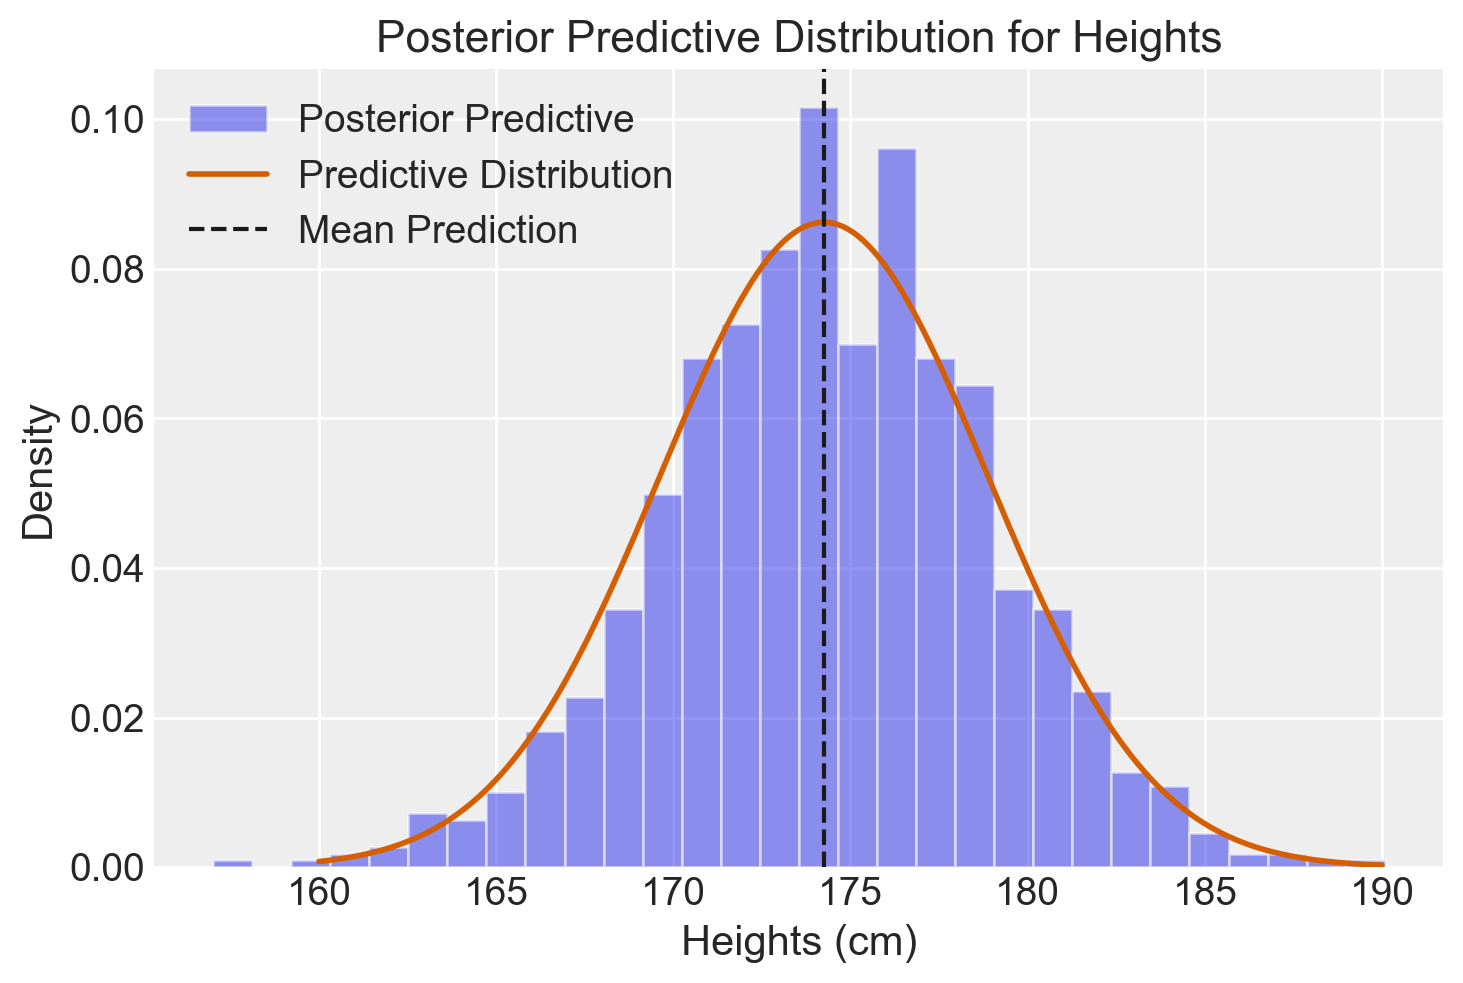

In [2]:
# Dati osservati
y_observed = np.random.normal(170, 10, 100)
mean_y = np.mean(y_observed)
std_y = np.std(y_observed)

# Parametri a priori
mu_0 = 175
tau_0 = 5

# Parametri posteriori
tau_n_sq = (tau_0**2 * std_y**2) / (tau_0**2 + std_y**2)
tau_n = np.sqrt(tau_n_sq)
mu_n = (tau_0**2 * mean_y + std_y**2 * mu_0) / (tau_0**2 + std_y**2)

# Parametri predittivi
n_fut = 100
sigma_pred_sq = tau_n_sq + (std_y**2 / n_fut)
sigma_pred = np.sqrt(sigma_pred_sq)
mu_pred = mu_n

# Simulazioni
y_pred_samples = np.random.normal(mu_pred, sigma_pred, 1000)

# Grafico
plt.hist(y_pred_samples, bins=30, density=True, alpha=0.5, label='Posterior Predictive')
x = np.linspace(160, 190, 200)
plt.plot(x, stats.norm.pdf(x, mu_pred, sigma_pred), 'r-', lw=2, label='Predictive Distribution')
plt.axvline(x=mu_pred, color='k', linestyle='--', label='Mean Prediction')
plt.xlabel('Heights (cm)')
plt.ylabel('Density')
plt.title('Posterior Predictive Distribution for Heights')
plt.legend()
plt.show()

Questo codice produce un grafico che illustra visivamente la distribuzione predittiva a posteriori per le altezze nel nostro campione di 100 nuove osservazioni, tenendo conto sia dei dati osservati che delle nostre aspettative iniziali.

In sintesi, la distribuzione predittiva a posteriori è stata generata nel modo seguente:

1. Campioniamo un valore $\mu$ dalla distribuzione a posteriori di $\mu$.
2. Campioniamo un valore $\sigma$ dalla distribuzione a posteriori di $\sigma$.
3. Utilizziamo questi valori per generare un campione dalla distribuzione normale con parametri $\mu$ e $\sigma$.
4. Ripetiamo questo processo molte volte.

La distribuzione dei valori ottenuti da questi campionamenti costituisce la distribuzione predittiva a posteriori.

## Metodo MCMC

Quando usiamo un PPL come Stan, la distribuzione predittiva viene stimata mediante il campionamento da una catena di Markov, che è particolarmente utile in scenari complessi dove l'analisi analitica potrebbe essere impraticabile. Attraverso i metodi MCMC, si stimano le potenziali osservazioni future $p(\tilde{y} \mid y)$, indicate come $p(y^{rep} \mid y)$, seguendo questi passaggi:

1. Si campiona $\theta_i \sim p(\theta \mid y)$: Viene selezionato casualmente un valore del parametro (o dei parametri) dalla distribuzione a posteriori.
2. Si campiona $y^{rep} \sim p(y^{rep} \mid \theta_i)$: Viene scelta casualmente un'osservazione dalla funzione di verosimiglianza, condizionata al valore del parametro (o dei parametri)ottenuto nel passo precedente.

Ripetendo questi due passaggi un numero sufficiente di volte, l'istogramma risultante approssimerà la distribuzione predittiva a posteriori. 

Esaminiamo ora come ottenere la distribuzione predittiva a posteriori con Stan per i dati dell'esempio precedente. Iniziamo creando le distribuzioni a posteriori di $\mu$ e $\sigma$.

In [3]:
stan_ncp_file = os.path.join(
    project_directory, 'stan', 'gaussian_ncp.stan')

model_ncp = CmdStanModel(stan_file=stan_ncp_file)

In [4]:
print(model_ncp.code())

data {
    int<lower=1> N;  // Total number of trials
    vector[N] y;  // Score in each trial
}
transformed data {
    real y_mean = mean(y);
    real y_sd = sd(y);
}
parameters {
    real mu_raw;
    real<lower=0> sigma_raw;
}
transformed parameters {
    real mu;
    real<lower=0> sigma;
    mu = y_mean + y_sd * mu_raw;
    sigma = y_sd * sigma_raw;
}
model {
    // Priors:
    mu_raw ~ normal(0, 1);  // Standard normal prior
    sigma_raw ~ normal(0, 1);  // Standard normal prior
    // Likelihood:
    y ~ normal(mu, sigma);
}
generated quantities {
    vector[N] y_rep;
    for (n in 1:N) {
        y_rep[n] = normal_rng(mu, sigma);
    }
}



Definiamo un dizionario che contiene i dati.

In [4]:
stan_data = {
    'N': len(y_observed), 
    'y': y_observed
}

print(stan_data)

{'N': 100, 'y': array([151.34959907, 161.87474001, 180.9672084 , 167.59394379,
       180.7798304 , 162.48032117, 174.20061623, 158.04766943,
       167.0843178 , 173.95235727, 162.18451031, 171.82643367,
       156.36842679, 189.97139157, 170.83694686, 157.36707192,
       188.09098291, 162.43878191, 172.39359701, 172.08447369,
       166.38609323, 184.06306935, 159.48411341, 168.82787815,
       179.03283479, 149.39803149, 169.21994529, 159.24390167,
       174.82668362, 145.21322638, 181.98542849, 165.96000676,
       169.64461627, 157.07809167, 166.11278189, 185.30291622,
       184.77412415, 178.66893581, 193.85561663, 185.93407244,
       163.21585722, 173.53698053, 167.19292134, 165.46126661,
       161.99483701, 164.5802656 , 165.58183346, 171.50326137,
       172.39460147, 174.80591039, 184.93695057, 168.48987961,
       173.02903824, 174.64981487, 182.05164045, 173.89586723,
       193.30641508, 173.60606837, 164.3852669 , 161.97893982,
       171.1393853 , 167.10284176, 174.

Eseguiamo il campionamento MCMC:

In [5]:
trace_ncp = model_ncp.sample(
    data=stan_data,
    iter_warmup = 1_000,
    iter_sampling = 2_000,
    seed = 123,
    show_progress = False, 
    show_console = False
)

07:59:51 - cmdstanpy - INFO - CmdStan start processing
07:59:51 - cmdstanpy - INFO - Chain [1] start processing
07:59:51 - cmdstanpy - INFO - Chain [2] start processing
07:59:51 - cmdstanpy - INFO - Chain [3] start processing
07:59:51 - cmdstanpy - INFO - Chain [4] start processing
07:59:51 - cmdstanpy - INFO - Chain [1] done processing
07:59:52 - cmdstanpy - INFO - Chain [2] done processing
07:59:52 - cmdstanpy - INFO - Chain [3] done processing
07:59:52 - cmdstanpy - INFO - Chain [4] done processing
07:59:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'gaussian_ncp.stan', line 24, column 4 to column 26)
Consider re-running with show_console=True if the above output is unclear!


Un sommario delle distribuzioni a posteriori dei parametri si ottiene nel modo seguente:

In [6]:
az.summary(trace_ncp, var_names=['mu', 'sigma'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,171.01,1.06,169.07,173.03,0.01,0.01,5891.50,4935.85,1.0
sigma,10.57,0.76,9.22,12.07,0.01,0.01,7188.48,4747.65,1.0


Convertiamo l'oggetto `sample_ncp` in un oggetto di classe InferenceData:

In [7]:
idata = az.from_cmdstanpy(
    posterior=trace_ncp, 
    posterior_predictive='y_rep', 
    observed_data={"y": y_observed}
)

La distribuzione predittiva a posteriori è utilizzata per eseguire i *controlli predittivi a posteriori* (PPC), noti come *Posterior Predictive Checks*. I PPC consistono in un confronto grafico tra $p(y^{rep} \mid y)$, ossia la distribuzione delle osservazioni future previste, e i dati osservati $y$. Questo confronto visivo permette di valutare se il modello utilizzato è adeguato per descrivere le proprietà dei dati osservati.

Oltre al confronto grafico tra le distribuzioni $p(y)$ e $p(y^{rep})$, è possibile effettuare un confronto tra le distribuzioni di varie statistiche descrittive calcolate su diversi campioni $y^{rep}$ e le corrispondenti statistiche calcolate sui dati osservati. Tipicamente, vengono considerate statistiche descrittive come la media, la varianza, la deviazione standard, il minimo o il massimo, ma è possibile confrontare qualsiasi altra statistica rilevante.

I controlli predittivi a posteriori offrono un valido strumento per un'analisi critica delle prestazioni del modello e, se necessario, per apportare eventuali modifiche o considerare modelli alternativi più adatti ai dati in esame.

Possiamo ora usare ArviZ per generare il posterior-predictive plot:

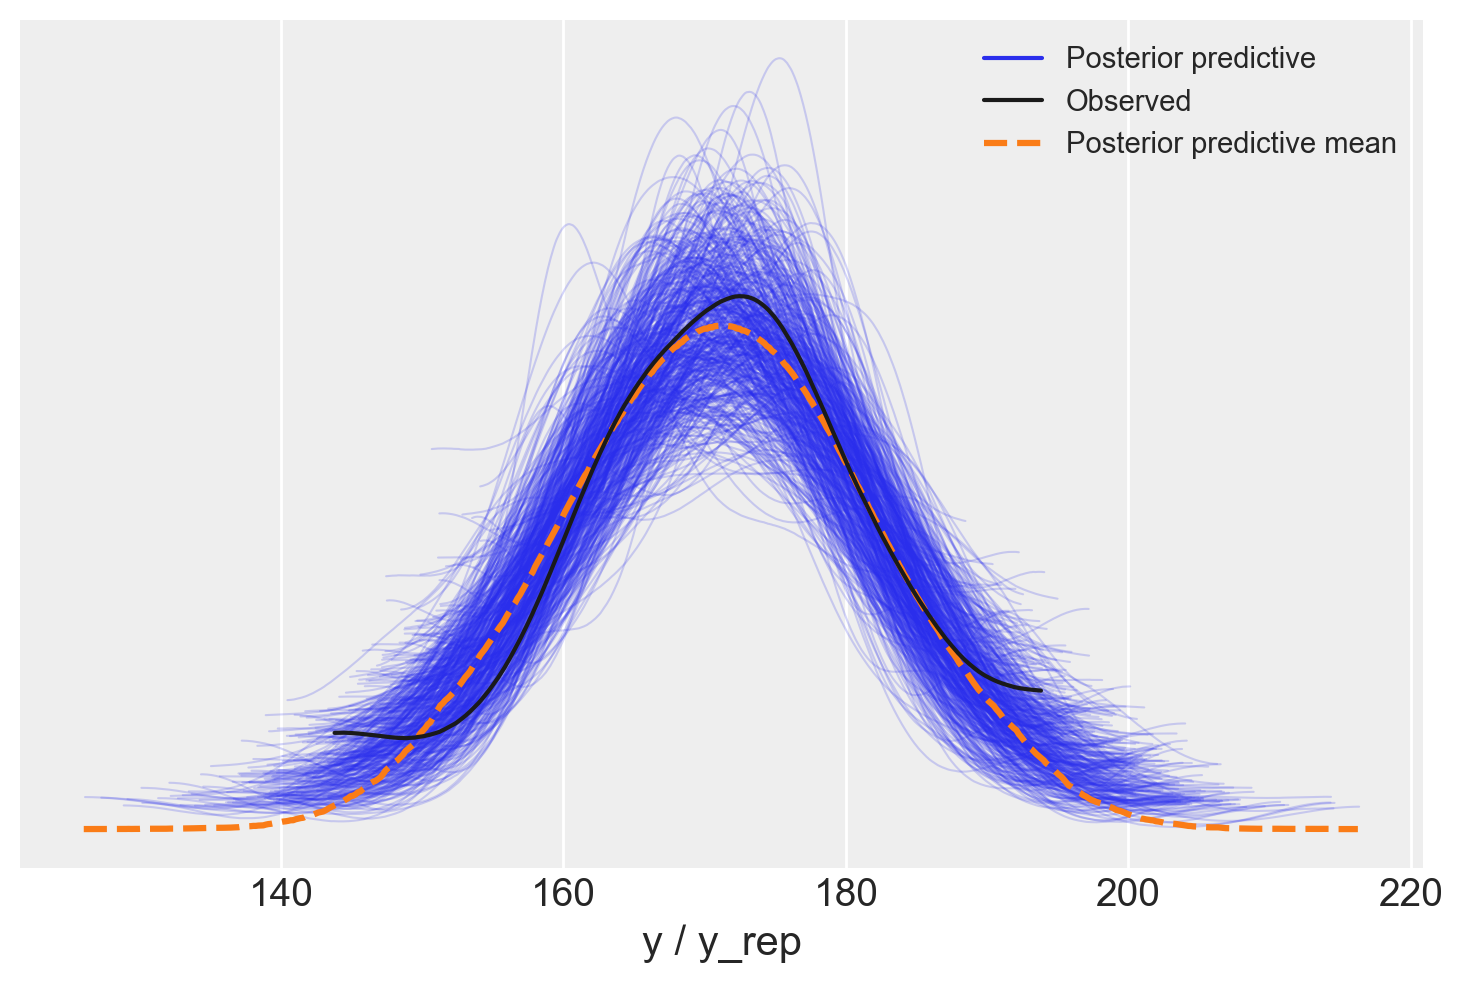

In [8]:
_ = az.plot_ppc(idata, data_pairs={"y": "y_rep"}, num_pp_samples=500)

## Distribuzione Predittiva a Priori

Le verifiche predittive a priori generano dati utilizzando unicamente le distribuzioni a priori, ignorando i dati osservati, al fine di valutare se tali distribuzioni a priori sono appropriate (Gabry et al. 2019). La distribuzione predittiva a priori è quindi simile alla distribuzione predittiva a posteriori, ma senza dati osservati, rappresentando il caso limite di una verifica predittiva a posteriori senza dati.

Questo processo può essere realizzato facilmente simulando i parametri secondo le distribuzioni a priori e poi simulando i dati in base al modello dati i parametri simulati. Il risultato è una simulazione dalla distribuzione congiunta, che è quindi una simulazione dalla distribuzione predittiva a priori.

Questa procedura è fondamentale per verificare se le ipotesi a priori sono realistiche e adeguate prima di raccogliere o utilizzare i dati osservati. Se i dati simulati dalla distribuzione predittiva a priori non risultano plausibili, potrebbe essere necessario rivedere le scelte delle distribuzioni a priori.

Consideriamo, quale esempio, il caso discusso in precedenza di un campione di dati gaussiani e di un modello gaussiano in cui le distribuzioni a priori per μ e σ sono gaussiane.

In [9]:
stan_file = os.path.join(
    project_directory, 'stan', 'gaussian_model_prior.stan')

model_gauss = CmdStanModel(stan_file=stan_file)

08:00:09 - cmdstanpy - INFO - compiling stan file /Users/corradocaudek/_repositories/psicometria/stan/gaussian_model_prior.stan to exe file /Users/corradocaudek/_repositories/psicometria/stan/gaussian_model_prior
08:00:18 - cmdstanpy - INFO - compiled model executable: /Users/corradocaudek/_repositories/psicometria/stan/gaussian_model_prior


In [10]:
print(model_gauss.code())

data {
  int<lower=0> N;            // number of observations
}
generated quantities {
  real mu;                   // parameter of interest
  real<lower=0> sigma;       // known standard deviation of y
  array[N] real y_rep;       // prior predictive samples

  // Priors
  mu = normal_rng(175, 5);
  sigma = 10;

  // Generate prior predictive samples
  for (n in 1:N) {
    y_rep[n] = normal_rng(mu, sigma);
  }
}



Il codice precedente illustra come definire il modello Stan per generare campioni predittivi a priori. In questo esempio, `mu` e `sigma` sono generati dalle loro rispettive distribuzioni a priori e usati per generare campioni di dati simulati `y_rep`.

In [11]:
# Stan data dictionary
stan_data = {
    'N': len(y_observed)
}

In [12]:
prior_predictive_samples = model_gauss.sample(
    data=stan_data, 
    fixed_param=True, 
    iter_sampling=1000, 
    iter_warmup=1, 
    chains=1,
    show_progress=False, 
    show_console=False
)

08:00:25 - cmdstanpy - INFO - CmdStan start processing
08:00:25 - cmdstanpy - INFO - Chain [1] start processing
08:00:25 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# Extract the relevant variables
y_rep_samples = prior_predictive_samples.stan_variable('y_rep')
y_rep_flattened = y_rep_samples.flatten()

# Check the statistics of y_rep values
y_rep_mean = np.mean(y_rep_flattened)
y_rep_std = np.std(y_rep_flattened)

print(f'Mean of y_rep: {y_rep_mean}')
print(f'Standard Deviation of y_rep: {y_rep_std}')

Mean of y_rep: 174.82592059000004
Standard Deviation of y_rep: 11.171402015673953


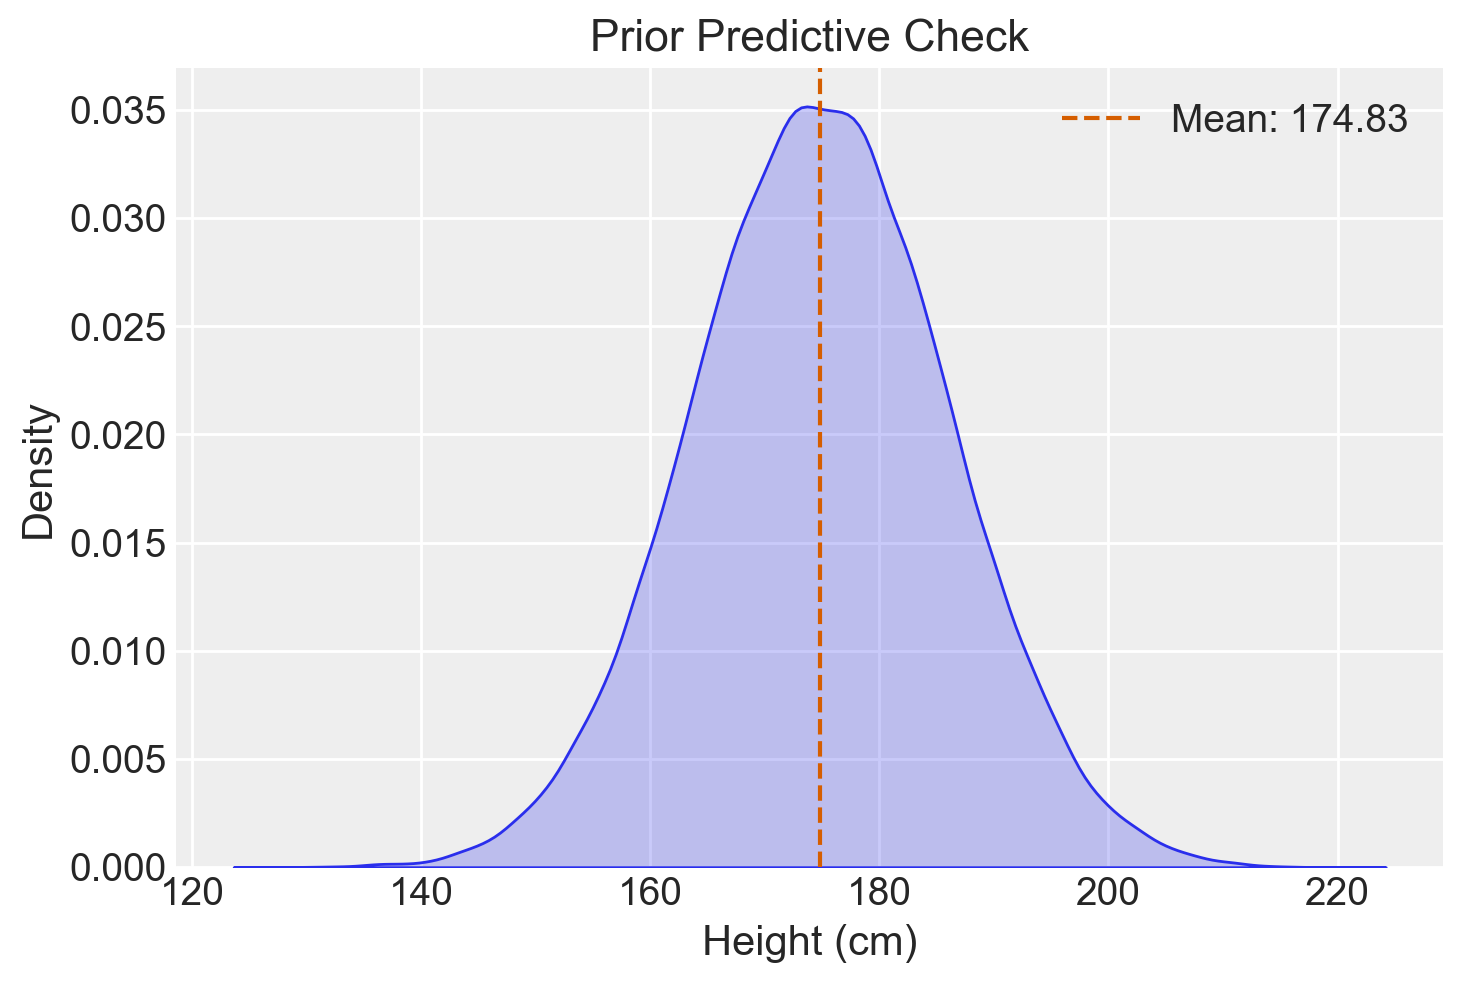

In [15]:
# Create a KDE plot
sns.kdeplot(y_rep_flattened, fill=True)
plt.title('Prior Predictive Check')
plt.xlabel('Height (cm)')
plt.ylabel('Density')
plt.axvline(x=y_rep_mean, color='r', linestyle='--', label=f'Mean: {y_rep_mean:.2f}')
plt.legend()
plt.show()

Questo approccio assicura che le distribuzioni a priori siano realistiche e adeguate, permettendo di identificare e correggere eventuali ipotesi errate prima di procedere con l'analisi dei dati osservati.

## Considerazioni conclusive

Le distribuzioni predittive a priori e a posteriori sono generate in maniera simile, con la seguente differenza.

- **Distribuzione Predittiva a Priori**: Questa distribuzione rappresenta le nostre previsioni sui dati prima di osservare qualsiasi dato effettivo. In questo caso, prendiamo valori dei parametri dalla distribuzione a priori e li utilizziamo nella funzione di verosimiglianza per generare dati predittivi. La distribuzione di questi dati generati è la nostra distribuzione predittiva a priori, che riflette le nostre conoscenze e incertezze prima dell'osservazione dei dati.

- **Distribuzione Predittiva a Posteriori**: Dopo aver osservato i dati, aggiorniamo le nostre credenze sulla distribuzione dei parametri usando il teorema di Bayes, ottenendo così la distribuzione a posteriori dei parametri. La distribuzione predittiva a posteriori viene generata prendendo valori dei parametri dalla distribuzione a posteriori (che incorpora le informazioni dai dati osservati) e inserendoli nella funzione di verosimiglianza per generare nuovi dati predittivi. Questa distribuzione riflette le nostre previsioni sui dati futuri o non osservati, dopo aver considerato i dati attuali.

La differenza chiave tra le due distribuzioni predittive è quindi la distribuzione dei parametri utilizzata per generare i dati: il prior nel caso della distribuzione predittiva a priori, e il posterior nel caso della distribuzione predittiva a posteriori. La distribuzione predittiva a posteriori è generalmente più informativa perché tiene conto dei dati osservati.

È fondamentale, per l'integrità del modello, che la distribuzione predittiva a posteriori rifletta la distribuzione dei dati osservati. Per validare questa corrispondenza, si utilizzano le verifiche predittive a posteriori, confrontando la distribuzione predittiva con i dati empirici tramite stime di densità Kernel (KDE). Questo confronto consente di valutare l'efficacia del modello nell'approssimare la struttura sottostante dei dati e la sua capacità di guidare previsioni affidabili.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w -m 

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Fri Aug 02 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

seaborn   : 0.13.2
matplotlib: 3.9.1
arviz     : 0.18.0
numpy     : 1.26.4
pandas    : 2.2.2
scipy     : 1.14.0

Watermark: 2.4.3

